In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import gzip
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [7]:
df = pd.read_csv('cse158-assignment2-master.csv')
df_small = df.sample(10000)

In [8]:
df_small.head()

,Unnamed: 0,winner.trophies,winner.isinclan,loser.trophies,loser.isinclan,winner.cards,winner.troops,winner.structures,winner.spells,winner.commons,...,winner.elixir.average,loser.cards,loser.troops,loser.structures,loser.spells,loser.commons,loser.rares,loser.epics,loser.legendaries,loser.elixir.average
3198425,3198425,5265.0,True,5250.0,True,"[26000000, 26000026, 26000030, 26000041, 27000...",4,1,3,3,...,3.250,"[26000000, 26000026, 26000030, 26000041, 27000...",4,1,3,3,2,1,2,3.250000
15490051,15490051,4183.0,True,4210.0,True,"[26000011, 26000012, 26000042, 26000062, 26000...",5,0,3,1,...,3.375,"[26000006, 26000020, 26000037, 26000043, 26000...",5,0,3,1,0,6,1,4.696429
7384488,7384488,5666.0,True,5690.0,True,"[26000016, 26000018, 26000049, 26000055, 26000...",6,0,2,4,...,3.625,"[26000005, 26000006, 26000008, 26000029, 26000...",5,1,2,3,3,1,1,4.000000
6648560,6648560,4804.0,True,4806.0,True,"[26000022, 26000031, 26000042, 27000006, 28000...",3,1,4,4,...,4.000,"[26000006, 26000013, 26000018, 26000037, 26000...",6,1,1,4,1,1,2,3.625000
3364162,3364162,5885.0,True,5894.0,True,"[26000006, 26000008, 26000029, 26000032, 26000...",6,0,2,4,...,4.125,"[26000006, 26000010, 26000014, 26000032, 26000...",5,1,2,2,3,1,2,2.875000


In [28]:
## Helper functions to generate new column names for rows separately for the 
## winner and loser for each match

def generate_winner_row(row):
    new_col_dict = {}    
    for col in df_small.drop(['winner.cards', 'loser.cards'], axis=1).columns:
        if 'winner' in col:
            new_col_dict['p_' + col.replace('winner.', '')] = row[col]
        if 'loser' in col:
            new_col_dict['opp_' + col.replace('loser.', '')] = row[col]
    new_col_dict['result'] = 1
    return new_col_dict

def generate_loser_row(row):
    new_col_dict = {}    
    for col in df_small.drop(['winner.cards', 'loser.cards'], axis=1).columns:
        if 'winner' in col:
            new_col_dict['opp_' + col.replace('winner.', '')] = row[col]
        if 'loser' in col:
            new_col_dict['p_' + col.replace('loser.', '')] = row[col]
    new_col_dict['result'] = 0
    return new_col_dict

In [32]:
## Creating new dataframe that has separate rows for 
## the winner and loser of each matchup
rows = []

for _, r in df_small.iterrows():
    # winner row
    rows.append(generate_winner_row(r))
    # loser row
    rows.append(generate_loser_row(r))

df2 = pd.DataFrame(rows)

In [34]:
## Fitting logistic regression

X = df2.drop(columns=["result"])
y = df2["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(solver='liblinear', random_state=42) # 'liblinear' is a good default solver
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.51425


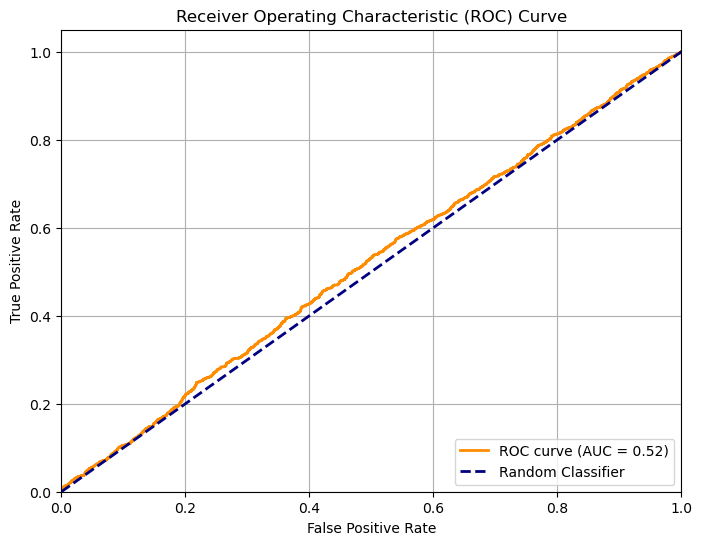

In [43]:
# Plotting ROC Curve

### Generating predicted values
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of belonging to class 1

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

### Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

### Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()